# Calculate Liquid Precipitation as Fraction of Total Precipitation

We calcuate liquid precipitation as a fraction of total precipitation for stations in the AROSS Rain on Snow Database.

In [1]:
import sys
sys.path.append("..")

from typing import List

from pathlib import Path
import calendar
import datetime as dt

from pyproj import CRS
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mcolors
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd
import numpy as np

from config import DATABASE_PATH, STATION_METADATA

HOURLY_DATA_PATH = DATABASE_PATH / "combined"

## Setup and Define plot and analysis parameters

In this section we define parameters for analysis and plotting.  We also setup fome objects to help with the analysis. 

In [2]:
# Select projection for maps - Orthographic or North Polar Stereographic
projection = "orthographic"

# Select minimum latitude for plots - minimum latitude of stations in the database is 53 deg. N
minimum_latitude = 50.

# Select whether to show map as square or circle
circle_plot = False

# Set to True to save plots as PNGs
savefigs = False

# Projection Definitions
projections = {
    # NSIDC WGS84 North Polar Stereographic CRS (EPSG:3413)
    "stereographic": ccrs.Stereographic(
        central_latitude=90., 
        central_longitude=0.,
        true_scale_latitude=70.
    ),
    # Simple Polar Azimuthal Orthographic - used by Zaria
    "orthographic": ccrs.Orthographic(
        central_latitude=90.,
        central_longitude=0.
    )
}
proj = projections[projection]

projection = "orthographic"  # Projection for plot
minimum_latitude = 60.  # Minimum latitude to plot
circle_plot = False

projections = {
    "stereographic": ccrs.Stereographic(central_latitude=90., central_longitude=0.),
    "orthographic": ccrs.Orthographic(central_latitude=90)
}
proj = projections[projection]

Create a `dict` of station data files indexed by four-letter station id.

In [3]:
def get_stid(fname):
    return fname.name.split(".")[0]
    
files = {get_stid(f): f for f in HOURLY_DATA_PATH.glob("*.csv")}

## The AROSS Database

<TBD>

### Metadata

Station metadata contains station name, latitude and longitude, state and country identifies indexed by station-id (`stdid`).  It is loaded as a `pandas.DataFrame` and converted to a Geopandas `GeoDataFrame`.

In [4]:
metadata = pd.read_csv(
    STATION_METADATA, 
    index_col=0,
    usecols=["stid","station_name","latitude","longitude",
             "elevation","country","ncei91"],
)
gmetadata = gpd.GeoDataFrame(metadata, 
                             geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude),
                             crs="EPSG:4326")
gmetadata.head()

,station_name,latitude,longitude,elevation,country,ncei91,geometry
stid,,,,,,,
PALP,Alpine,70.34430,-150.94470,7.998743,US,USC00500235,POINT (-150.9447 70.3443)
PAFM,AMBLER,67.10631,-157.85747,88.000000,US,USC00503212,POINT (-157.85747 67.10631)
PAKP,ANAKTUVUK PASS,68.13360,-151.74334,643.000000,US,USW00026533,POINT (-151.74334 68.1336)
PANC,ANCHORAGE INTL ARPT (ASOS),61.16972,-150.02611,40.000000,US,USW00026451,POINT (-150.02611 61.16972)
PANV,ANVIK AIRPORT,62.64733,-160.19007,99.000000,US,USW00026502,POINT (-160.19007 62.64733)


### Combined Data

Combined data files contain hourly observations of temperature, humidity, wind speed, precipitation type, and snow on the ground for all stations in the database.  Some stations include hourly precipitation intensity.  These hourly observation files are created by aggregating the raw ASOS observations from the original station observing frequency.  This varies depending on country.  Most countries report conditions hourly.

_This statment needs to be checked._

For this analysis, we are interested in precipitation type, so only these columns are loaded.  

:::{note}
Additional columns could be loaded by adding the column names to the list passed to `usecols`.
:::

#### Evaluate Data Coverage

For a robust analysis, we need to ensure there is a sufficient period of record to estimate statistics.  To do this, we compare the number of precipitation type observations in each month against the mean monthly count of observations for each station.  If each count is with the 10th and 90th percentile, that month is marked as representative for the station.  Months with counts that fall outside this range are flagged as erroneous.

In [5]:
%%time

def load_ptype(fp: Path, stid: str) -> pd.Series:
    """Load precipitation type observations and set to True is any
    precipitation type (UP or RA or FZRA or Solid) is True

    Argument
    --------
    fp : filepath
    stid : station id
    
    Returns
    -------
    pandas.Series of booleans, where True indicates one of UP, RA, FZRA or SOLID recorded
    """
    return pd.read_csv(fp, index_col="datetime", parse_dates=True, low_memory=False, 
                       usecols=["datetime","UP","RA","FZRA","SOLID"]).any(axis=1).rename(stid)

ptype_count = pd.concat([load_ptype(fpath, stid) for stid, fpath in files.items()], axis=1)
ptype_count = ptype_count["1979":].resample("MS").sum().astype(float)  # count monthly occurrances
ptype_count = ptype_count.sort_index(axis=1)  # Sort column index for nice plotting
ptype_count.head()

CPU times: user 1min 28s, sys: 11.9 s, total: 1min 40s
Wall time: 1min 40s


,BGAA,BGBW,BGCO,BGGH,BGJN,BGKK,BGMQ,BGPT,BGQQ,BGSF,...,USDD,USHH,USMM,USMU,USNN,USRK,USRR,UUYH,UUYS,UUYY
datetime,,,,,,,,,,,,,,,,,,,,,
1979-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='datetime'>

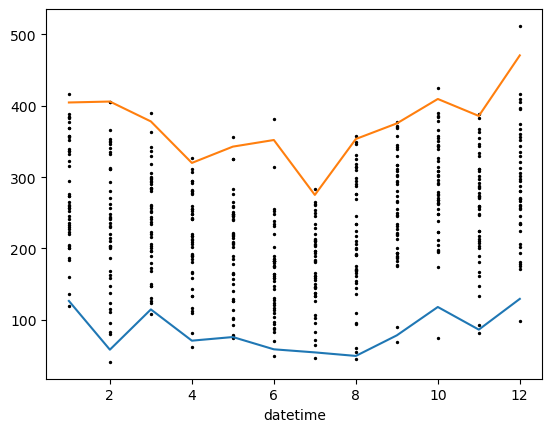

In [6]:
percentile = ptype_count["PAYA"].groupby(ptype_count.index.month).quantile([0.01, 0.99]).unstack(level=-1)

fig, ax = plt.subplots()

ax.scatter(ptype_count.index.month, ptype_count["PAYA"], c='k', s=2)
percentile[0.01].plot(ax=ax)
percentile[0.99].plot(ax=ax)

# ptype_count["PAYA"]["1979":].plot(kind="scatter", x=ptype_count.index.month, )

Add `nyear` as the number of complete years of ptype observations.

In [7]:
gmetadata["nyear"] = ((ptype_count > 0).resample("YS").sum() == 12).sum()
gmetadata

,station_name,latitude,longitude,elevation,country,ncei91,geometry,nyear
stid,,,,,,,,
PALP,Alpine,70.34430,-150.94470,7.998743,US,USC00500235,POINT (-150.9447 70.3443),17
PAFM,AMBLER,67.10631,-157.85747,88.000000,US,USC00503212,POINT (-157.85747 67.10631),7
PAKP,ANAKTUVUK PASS,68.13360,-151.74334,643.000000,US,USW00026533,POINT (-151.74334 68.1336),5
PANC,ANCHORAGE INTL ARPT (ASOS),61.16972,-150.02611,40.000000,US,USW00026451,POINT (-150.02611 61.16972),44
PANV,ANVIK AIRPORT,62.64733,-160.19007,99.000000,US,USW00026502,POINT (-160.19007 62.64733),3
...,...,...,...,...,...,...,...,...
ESNU,Umea,63.79183,20.28276,14.000000,SE,NaN,POINT (20.28276 63.79183),13
ESCM,Uppsala,59.89730,17.58860,21.829485,SE,NaN,POINT (17.5886 59.8973),4
ESOW,Vasteras,59.58944,16.63361,31.000000,SE,NaN,POINT (16.63361 59.58944),13


## Plot stations with months of observations

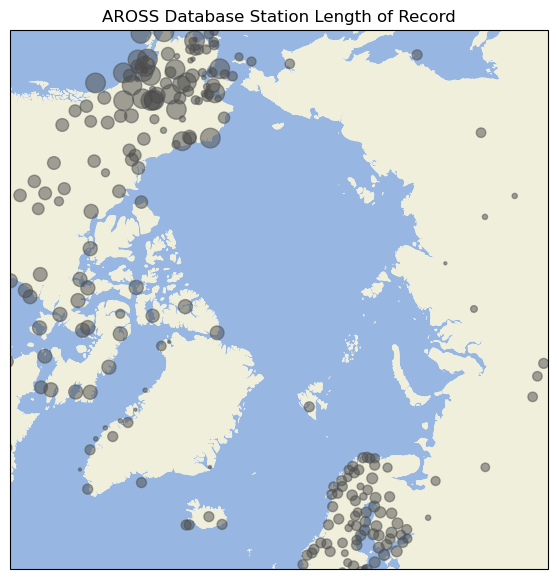

In [8]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=proj)
ax.set_extent([-180.,180.,minimum_latitude,90.], ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

# Normalize observation counts
s = ((gmetadata["nyear"] - gmetadata["nyear"].min()) / 
     (gmetadata["nyear"].max() - gmetadata["nyear"].min()))
max_ms = 200  # Maximum Markersize

gmetadata.to_crs(6931).plot(ax=ax, color='0.3', markersize=s*max_ms, legend=True, alpha=0.5)

ax.set_title("AROSS Database Station Length of Record")

# TODO: add legend

if savefigs:
    fig.savefig("aross_stations.png")

22% (54) of stations have records with more than 20 years of data.

Text(5, 50, '50%')

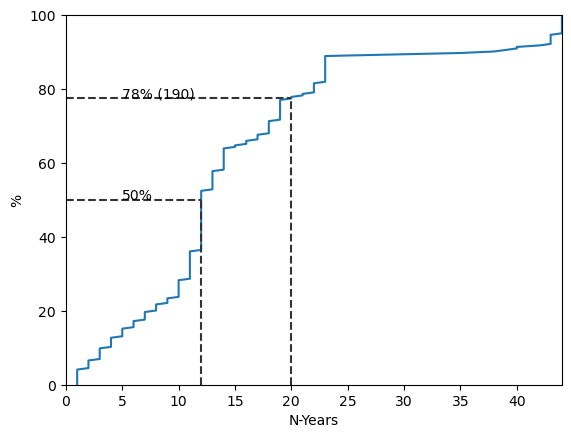

In [9]:
x = gmetadata["nyear"].sort_values()
y = np.arange(len(x)) * 100. / len(x)

fig, ax = plt.subplots()

ax.set_ylim(0,100)
ax.set_xlim(0,x.max())
ax.set_ylabel("%")
ax.set_xlabel("N-Years")
ax.plot(x, y)

threshold = 20
ymax = np.where(x.values == 20)[0].mean() / len(x)
ax.axvline(threshold, ymax=ymax, c='0.2', ls="--")
ax.axhline(ymax*100., xmax=threshold/x.max(), c='0.2', ls="--")
ax.text(5, ymax*100, f"{ymax*100:2.0f}% ({np.ceil(ymax*len(x)):2.0f})", )

xmax = np.quantile(x, 0.5)
ax.axvline(xmax, ymax=0.5, c='0.2', ls="--")
ax.axhline(50, xmax=xmax/x.max(), c='0.2', ls="--")
ax.text(5, 50, "50%")

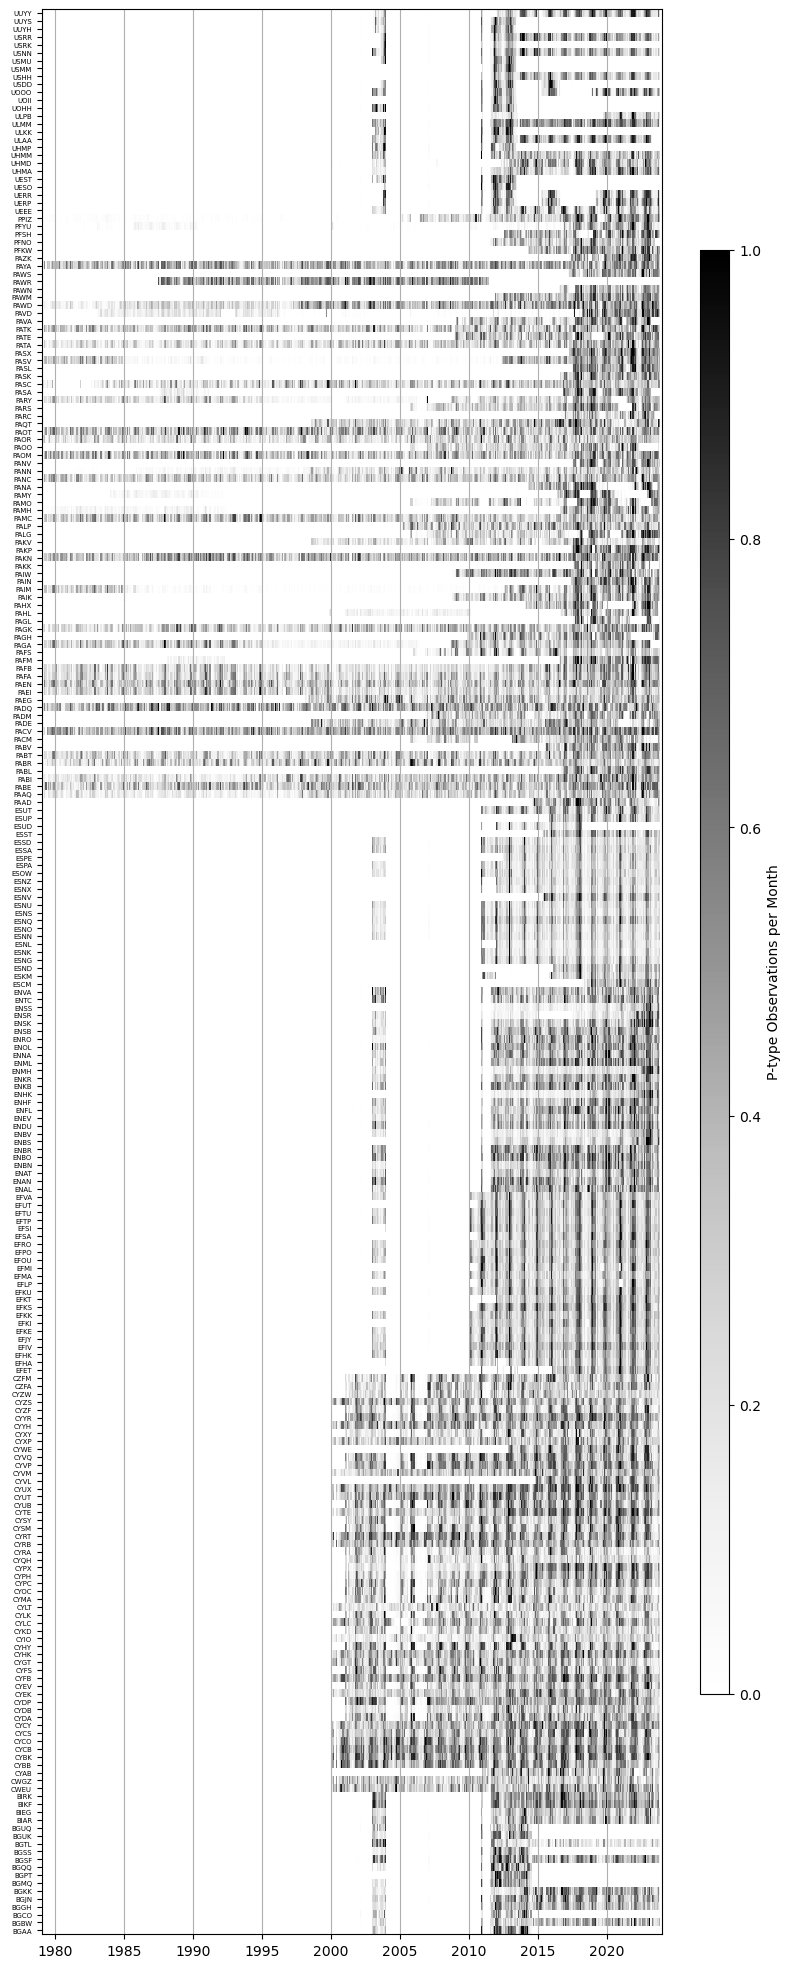

In [10]:
def minmax_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

ptype_count_scl = ptype_count.apply(minmax_scaler)

fig, ax = plt.subplots(figsize=(10,25))

ntime, nstation = ptype_count_scl.shape
ax.set_xlim(dt.datetime(1979,1,1), dt.datetime(2023,12,31))
img = ax.imshow(ptype_count_scl.T.values, 
                extent=[ptype_count_scl.index.min(), ptype_count_scl.index.max(),
                        0, nstation],
                interpolation="none",
                origin="lower", aspect="auto",
                cmap="Greys")

ax.set_yticks(np.arange(nstation)+0.5, ptype_count_scl.columns, fontsize=5);
ax.grid(which="major", axis="x")

fig.colorbar(img, shrink=0.75, label="P-type Observations per Month", aspect=50);

# fig.savefig("hourly_observations_per_month.png")

## Frequency of liquid precipitation by season

A measure of the prevalence of liquid precipitation at a station for climatological seasons is given by the number of hours with a report of a liquid precipitation expressed a fraction of the total number of hours with any type of precipitation reported.  Below we show how this is calculated for a single station before applying the algorithm to all stations in the database.

## For a single Station

We use hourly observations.  For each station, precipitation type is recorded as rain (RA), freezing rain (FZRA) and solid (SOLID).  There is also an "unknow precipitation" (UP) type, which during winter generally indicates liquid precipitation.  Solid precipitation includes any form of non-liquid precipitation.  Freezing rain is liquid precipitation that passes through a supercooled air layer and freezes on contact with surfaces.

In [11]:
df = pd.read_csv(files["PAYA"], index_col=0, parse_dates=True, low_memory=False)
df.head()

,station,t2m,d2m,relh,mslp,psurf,p01i,UP,RA,FZRA,SOLID,wspd,drct,sog
datetime,,,,,,,,,,,,,,
1941-05-01 14:00:00,PAYA,1.3,1.3,100.00,1004.5,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,NaN
1941-05-01 15:00:00,PAYA,3.0,2.4,95.83,1003.8,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,NaN
1941-05-01 16:00:00,PAYA,5.8,4.6,91.99,1004.3,NaN,NaN,NaN,NaN,NaN,NaN,0.51,135.0,NaN
1941-05-01 17:00:00,PAYA,6.9,4.6,85.27,1004.8,NaN,NaN,NaN,NaN,NaN,NaN,2.57,90.0,NaN
1941-05-01 18:00:00,PAYA,8.5,3.5,70.78,1004.4,NaN,NaN,NaN,NaN,NaN,NaN,1.03,90.0,NaN


We classify liquid precipitation as a combination of RA, FZRA and UP types.  Hours that report RA or FZRA or UP are counted for climatological seasons in each year.  These counts are divided by the total number of hours in which any precipitation type was reported for that season.  Liquid precipitation frequencies for each season are then averaged to get a seasonal climatology.

In [12]:
all_ptypes = ["UP","RA","FZRA","SOLID"]

def liquid_precipitation_ratio(df: pd.DataFrame, 
                               liquid: List=["UP","RA","FZRA"], 
                               rule: str="season") -> pd.Series:
    """Calculates the ratio of liquid precipitation types as a fraction of
    of all precipitation types.

    Arguments
    ---------
    df : pandas.DataFrame with a time index that contains precipitation type codes
    liquid : list of codes to include as liquid precipitation
    rule : resampling rule.  Expects `"season"`, `"month"` or `"none"`.  `"season"`
           translates to pandas resampling rule `"QS-DEC"`, quarterly resampling starting on
           1 December. 

    Returns
    -------
    pandas.Series containing liquid precipitation ratios for given resampling frequency.  If
    all precipitation types are Null, then NaN is returned.
    """
    rules = {
        "season": "QS-DEC",
        "month": "MS",
    }
    freq = rules.get(rule, rule)
    
    return (df[liquid].any(axis=1).resample(freq).sum() / 
            df[all_ptypes].any(axis=1).resample(freq).sum())

def to_season(df):
    """Returns integer code for climatological season

    0 - DJF
    1 - MAM
    2 - JJA
    3 - SON
    """
    return (df.index.month // 3) % 4

Calculate seasonal liquid precipitation frequency.

In [13]:
ratio = liquid_precipitation_ratio(df)

<Axes: xlabel='datetime'>

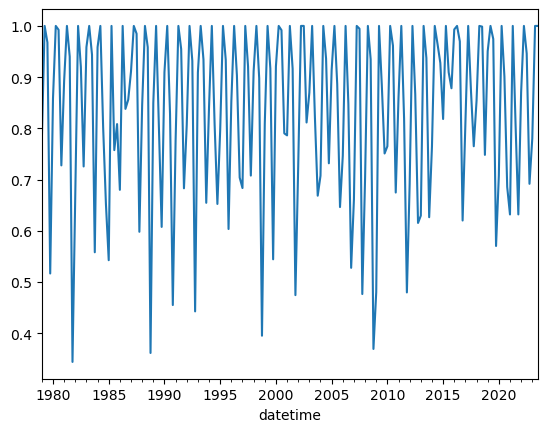

In [14]:
ratio["1979":].plot()

Calculate seasonal climatology.

In [15]:
ratio.groupby(to_season(ratio)).mean().set_axis(pd.Index(["DJF","MAM","JJA","SON"]))

DJF    0.562820
MAM    0.763477
JJA    1.000000
SON    0.903619
dtype: float64

Here I test the uncertainty associated with estimating seasonal climatologies of liquid precipitation frequency.

1. For `nsample` samples of `nyears = 10 to 44` calculate seasonal mean frequencies.
2. Plot samples

In [16]:
# np.random.seed = 42

# nsample = 100

# n = 20
# for i in np.arange(nsample):
#     sample = pd.concat([ratio[str(year)] for year in np.random.randint(1979, 2023, n)])
#     sample.groupby(to_season(sample)).mean().set_axis(pd.Index(["DJF","MAM","JJA","SON"]))

## All Stations

Look for stations with more than 20 years of data

In [17]:
# these_stations = ptype_count.columns[(ptype_count["1979":"2023"].resample("YS").sum() > 0).sum() >= 20]
# for i, station in enumerate(these_stations, 1):
#     print(f"{i:2d} {station}")

Calculate rain event ratios

In [18]:
%%time

def load_ratios(fpath, stid):
    df = pd.read_csv(fpath, index_col=0, parse_dates=True, low_memory=False)
    ratio = liquid_precipitation_ratio(df)
    return ratio.rename(stid)

df_ratios = pd.concat([load_ratios(fpath, stid) for stid, fpath in files.items()], axis=1)

df_ratios = df_ratios["1979":"2023"]
df_ratios_clm = df_ratios.groupby(to_season(df_ratios)).mean().set_index(pd.Index(["DJF","MAM","JJA","SON"])).T
df_ratios_clm

CPU times: user 1min 54s, sys: 649 ms, total: 1min 55s
Wall time: 1min 55s


,DJF,MAM,JJA,SON
CYDB,0.006815,0.307364,0.988647,0.210701
PADQ,0.674955,0.807603,1.000000,0.895738
ENFL,0.793912,0.940007,1.000000,0.994658
EFMA,0.463418,0.755914,1.000000,0.921464
PAHX,0.136180,0.531311,1.000000,0.747802
...,...,...,...,...
BGSS,0.056895,0.143203,0.968862,0.387444
ULPB,0.117213,0.458416,1.000000,0.689336
EFTU,0.339084,0.728491,1.000000,0.816416
BGSF,0.039451,0.109796,0.971271,0.309303


In [19]:
gmetadata = gmetadata.join(df_ratios_clm)

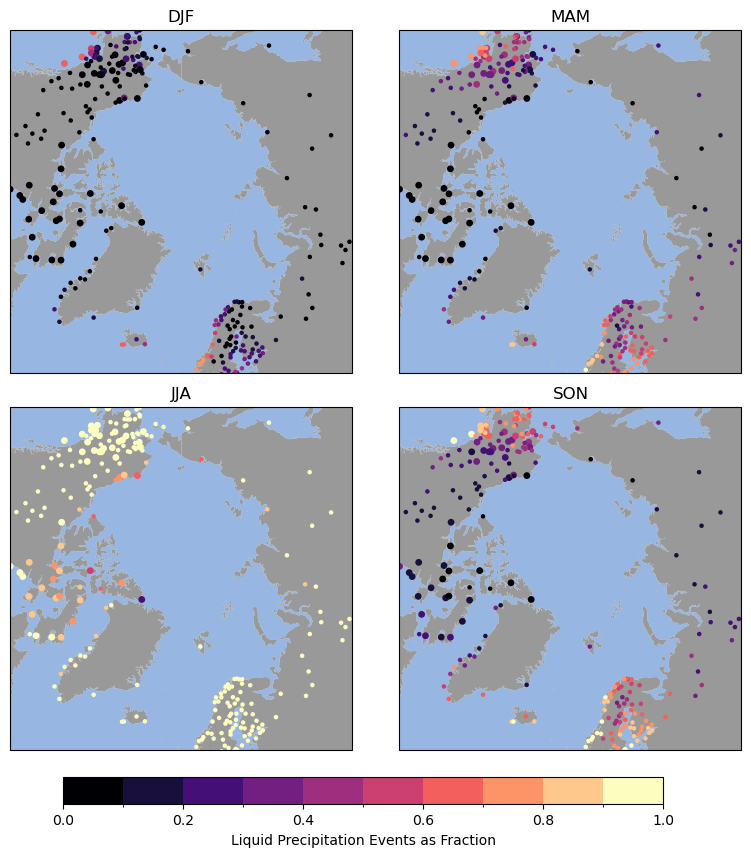

In [20]:
import cmocean 

# Set these parameters to control plotting
threshold_nyear = 20  # Minimum number of years required to plot station

# Define normalization and colormap
bounds = np.linspace(0.,1.,11)
norm = mcolors.BoundaryNorm(bounds, ncolors=256)
cmap = "magma"  #"viridis_r"  #cmocean.cm.rain  #"cool"  #"Blues"

# Define Circular boundary for the polar projection
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig = plt.figure(figsize=(10,9))
axes = []
for i, season in enumerate(["DJF", "MAM", "JJA", "SON"], 1):
    ax = fig.add_subplot(2, 2, i, projection=proj)
    ax.set_extent([-180.,180.,minimum_latitude,90.], ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, facecolor="0.6")

    if circle_plot:
        ax.set_boundary(circle, transform=ax.transAxes)

    img = gmetadata[gmetadata.nyear > threshold_nyear].to_crs(6931).plot(
        ax=ax, markersize=15, column=season,
        legend=False, vmin=0., vmax=1.,
        norm=norm, cmap=cmap)
    img = gmetadata[gmetadata.nyear <= threshold_nyear].to_crs(6931).plot(
        ax=ax, markersize=5, column=season,
        legend=False, vmin=0., vmax=1.,
        norm=norm, cmap=cmap)
    ax.set_title(season)

    axes.append(ax)

# Add colorbar axis
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.1, wspace=0.01)
cax = fig.add_axes((0.2, 0.04, 0.6, 0.03))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=cax, orientation="horizontal", 
             label="Liquid Precipitation Events as Fraction")

fig.savefig("frequency_liquid_precipitation_events_by_season.png")

### Write results to file

In [21]:
gmetadata.drop("geometry", axis=1).rename({"nobs": "nyear"}, axis=1).to_csv("fraction_liquid_precipitation_events.csv")